# Water Allocation Simulation Analysis
This notebook provides tools to analyze the results of the water allocation simulation
across multiple scenarios, focusing on ecological and economic impacts under different
conditions.

## Overview
The simulation tests water allocation policies across various scenarios with different:
- River basins (station configurations)
- Actor compositions (different archetypes from the paper)
- Water scarcity levels
- Forecast error profiles (bias and uncertainty)

The analysis evaluates how these factors affect both ecological integrity and economic benefits.


In this notebook we will:
1. Run the set of evaluation scenarios varying station size, scarcity level,  
   forecast bias and uncertainty.
2. Collect ecological and economic impact metrics for each run.
3. Visualize trade-offs and explore how model parameters influence outcomes.

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from types import MethodType
import src.core as wms
import src.plot_analysis as gtp
import src.utils as utils
import src.policies.incentive_policies as eip
import src.policies.quota_policies as eqp
import src.scenarios as sc
import src.utils as utils
import src.plot_multi_analysis as pma
import src.policies.incentive_policies as eip
import src.policies.quota_policies as eqp

# Set better visualization defaults
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

In [2]:
# define your custom quota policy 
def custom_quota(self, 
                crisis_level: int, # for testing purposes only you can't use it in your final policy
                actors_priority: np.ndarray,
                avg_pump: np.ndarray,
                DOE: float,
                DCR: float) -> np.ndarray:
    """
    Compute the quota for each actor based on the crisis level.
    
    Parameters:
    -----------
    crisis_level : int
        Current water crisis level (-1: Normal, 0: Alert, 1: High-Alert, 2: Crisis)
    actors_priority : np.ndarray
        Priority level of each actor (2: High, 1: Medium, 0: Low)
    avg_pump : np.ndarray
        Average water pumped by each actor over the past year
    DOE : float
        Objective Low-Water Flow threshold
    DCR : float
        Crisis Flow threshold
        
    Returns:
    --------
    np.ndarray
        Array of quotas for each actor
    """
    # Default implementation: use hard quota policy from example
    return avg_pump

# or use the example incentive policy
# custom_quota = eqp.hard_quota

In [3]:
# define your custom quota policy 
def custom_incentive_policy(self,
                        actions: np.ndarray, # for testing purposes only you can't use it in your final policy
                        actors_priority: np.ndarray,
                        avg_incomes: np.ndarray,
                        water_pump: np.ndarray,
                        avg_pump: np.ndarray,
                        is_crisis: np.ndarray,
                        water_flows: np.ndarray,
                        quota: np.ndarray,
                        DOE = 15,
                        DCR = 10) -> np.ndarray:
    """
    Compute fines or subsidies for each actor based on their actions and water usage.
    
    Parameters:
    -----------
    actions : np.ndarray
        Boolean array indicating which actors cooperated (True) or defected (False)
    actors_priority : np.ndarray
        Priority level of each actor (2: High, 1: Medium, 0: Low)
    avg_incomes : np.ndarray
        Average income for each actor over the past year
    water_pump : np.ndarray
        Water pumped by each actor in current turn
    avg_pump : np.ndarray
        Average water pumped by each actor over the past year
    is_crisis : np.ndarray
        Crisis levels for past turns, including current turn
    water_flows : np.ndarray
        River flows for past turns, including current turn
    quota : np.ndarray
        Quota for each actor in current turn
    DOE : float
        Objective Low-Water Flow threshold
    DCR : float
        Crisis Flow threshold
        
    Returns:
    --------
    np.ndarray
        Array of fines (positive values) or subsidies (negative values) for each actor
    """
    # Default implementation: no incentive policy
    return np.zeros_like(actors_priority)

# or use the example incentive policy
# custom_incentive_policy = eip.no_policy

## Scenario Definition
Runs simulations across the pre-defined scenarios.
We iterate over:
- **Stations**: Tarn vs. La Vézère  
- **Scarcity levels**: low / medium / high  
- **2 set of actors and variant with heterogenous biaises and uncertainties**  
- **Forecast bias/uncertainty** settings  


In [4]:
if False:
    results_df = sc.run_all_scenarios(
        turns=700,
        iterations=2,
        custom_incentive_policy=custom_incentive_policy,
        custom_quota=custom_quota)



## Multi-Scenario Analysis


Save the results if needed.

In [5]:
# save results_df to csv
# results_df.to_csv('results_df.csv', index=False)

# load results_df from csv
results_df = pd.read_csv('results_df.csv')


### Ecological vs. economic impact.

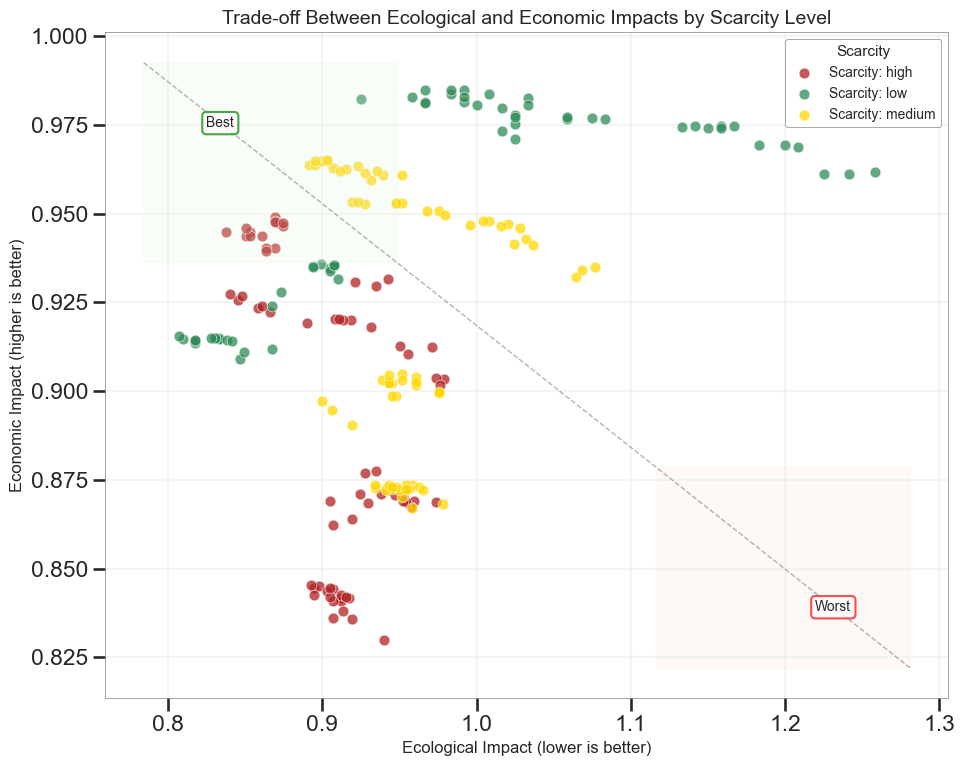

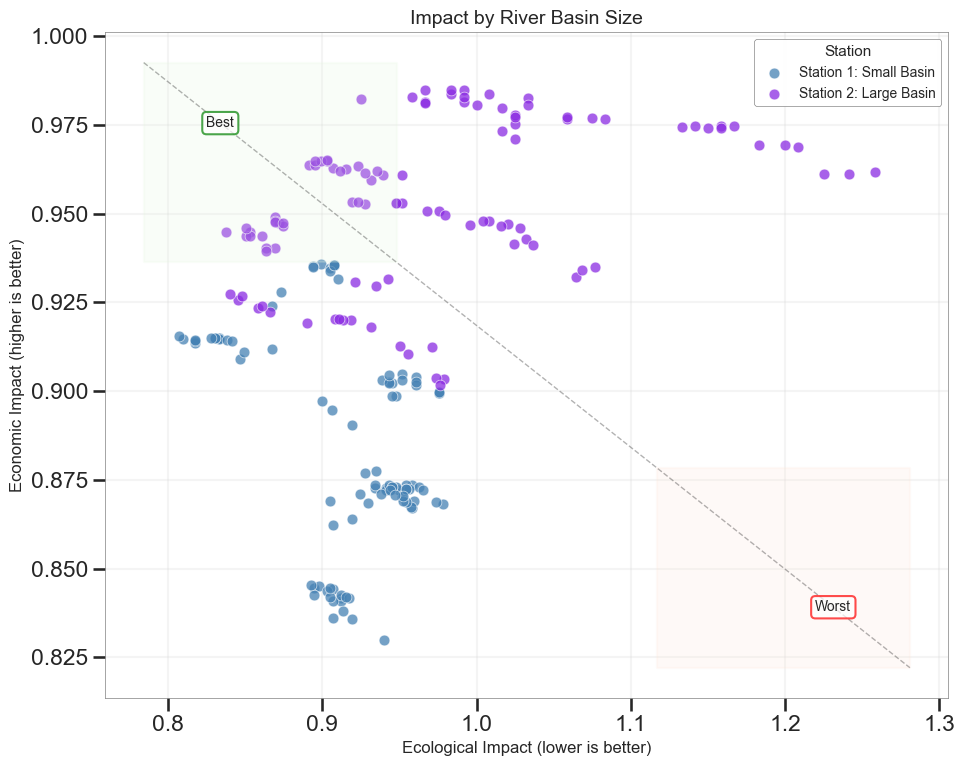

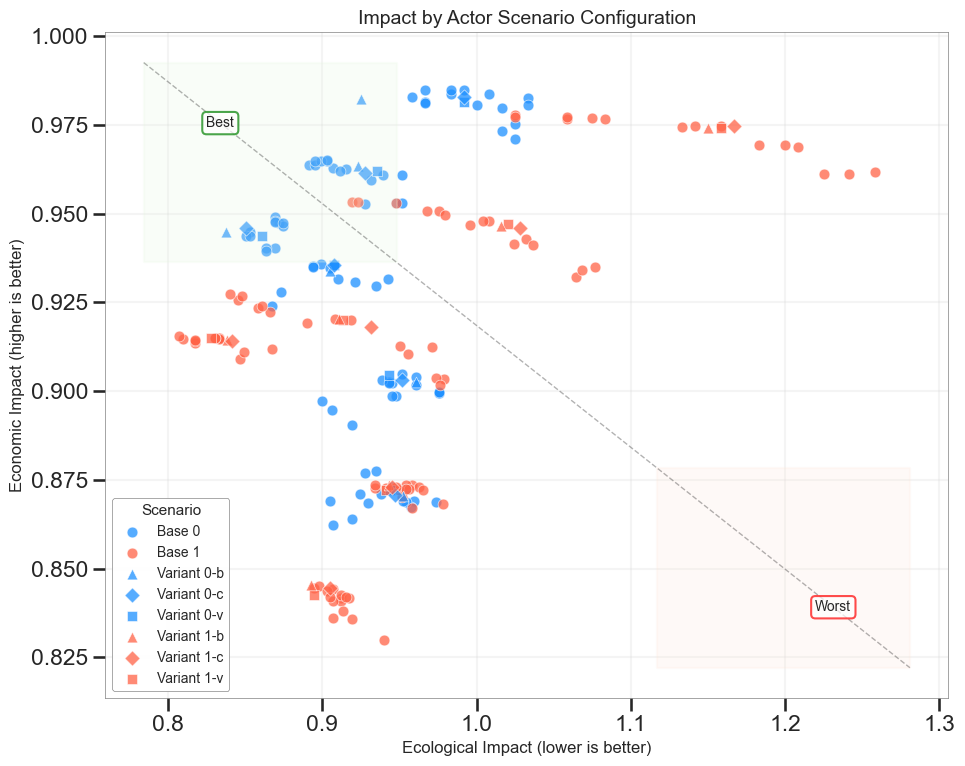

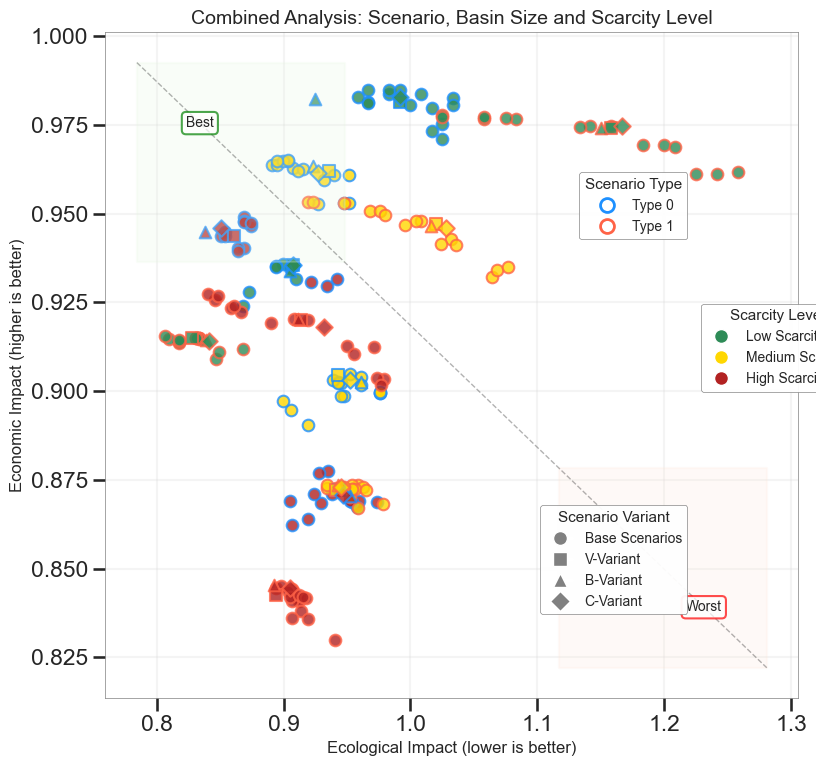

In [6]:
pma.analyze_scenario_impacts(results_df)

## Analyzing Forecast Bias & Uncertainty & Scarcity levels

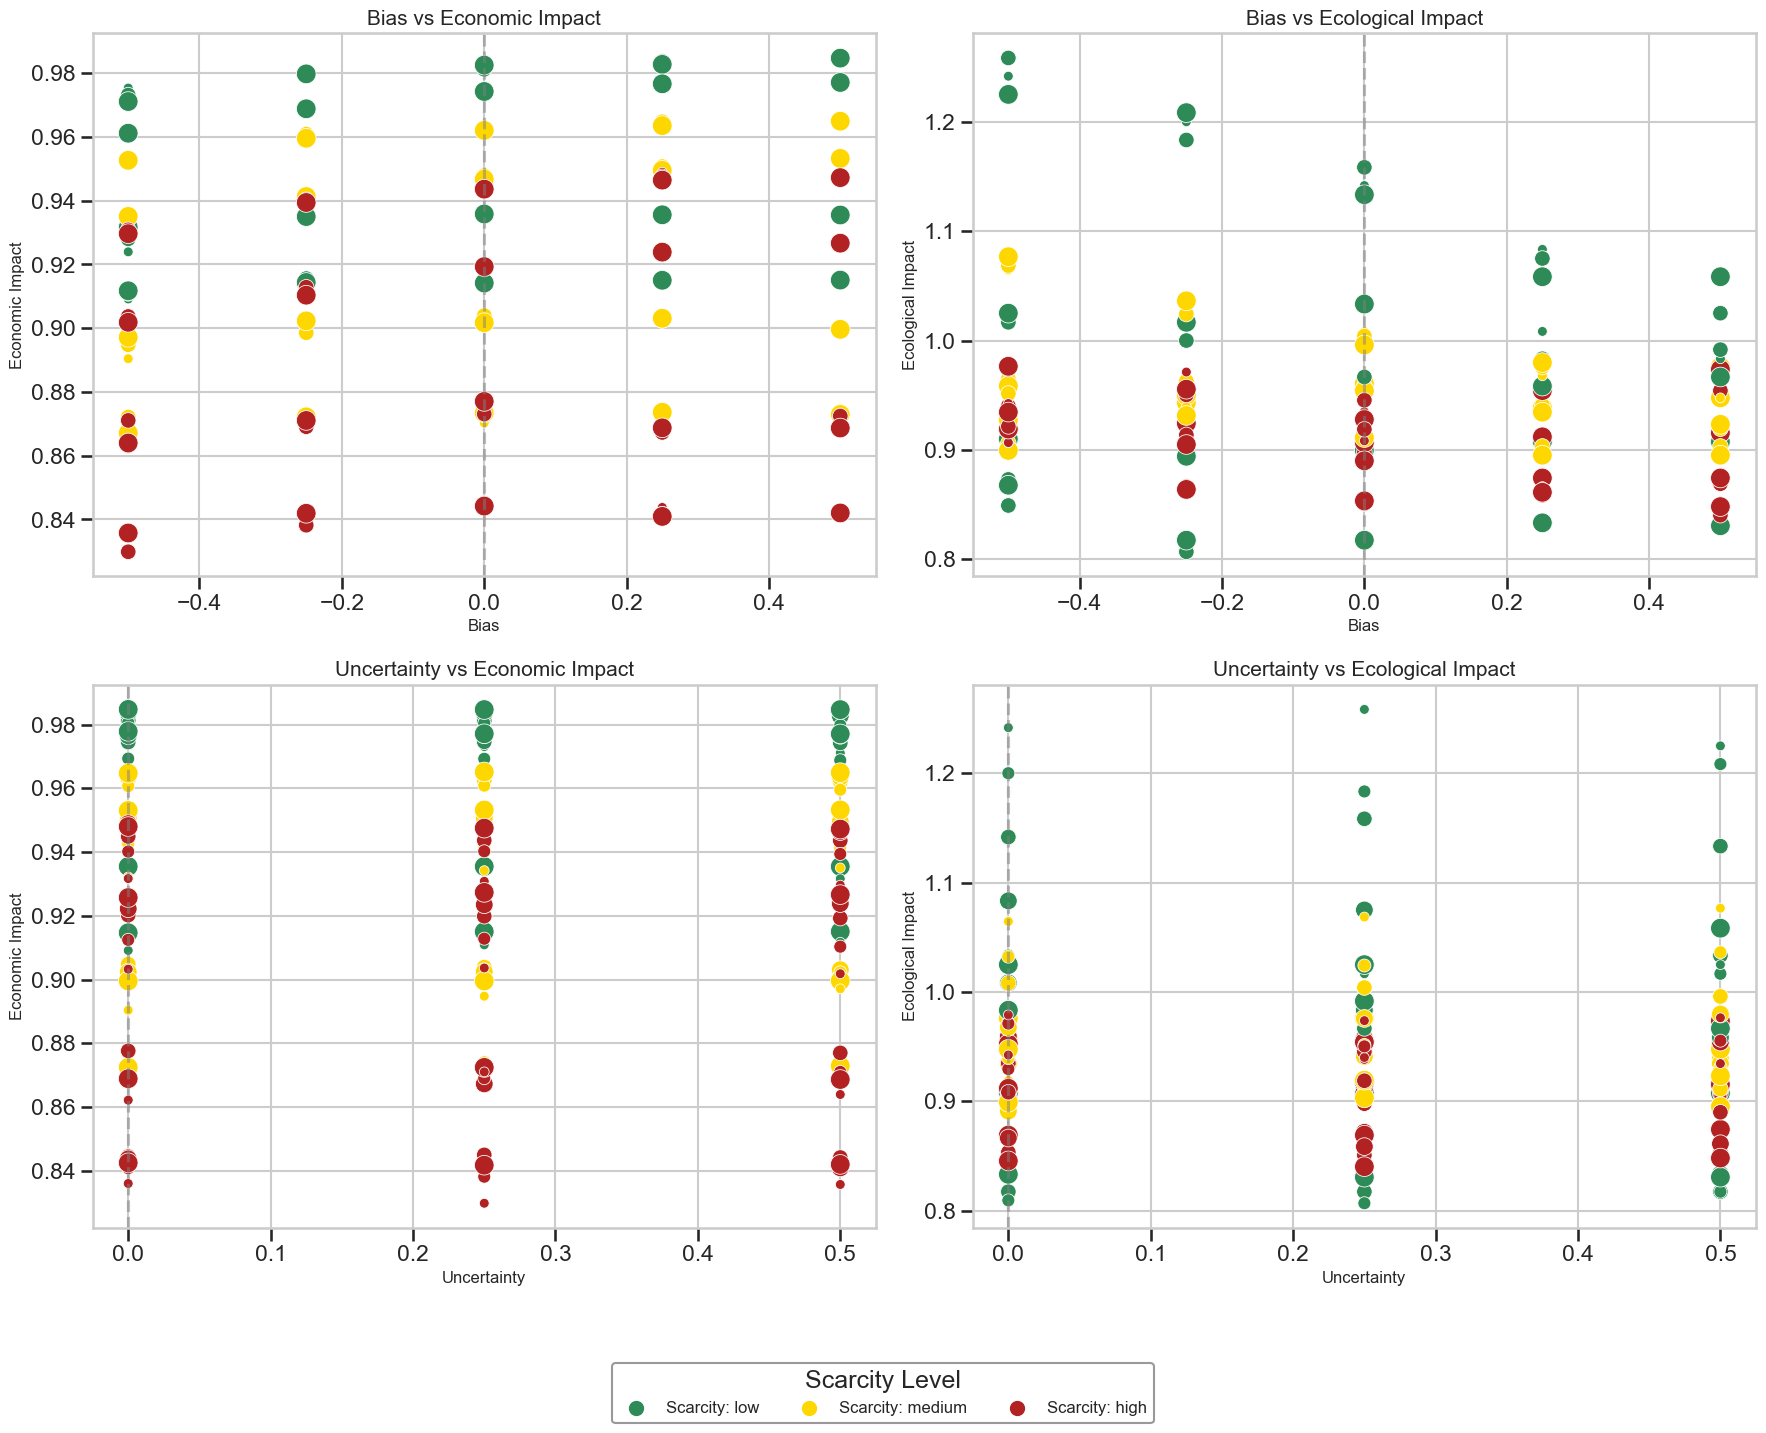

/Users/david/python_projects/GameTheory/src/plot_multi_analysis.py:307: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/Users/david/python_projects/GameTheory/src/plot_multi_analysis.py:307: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


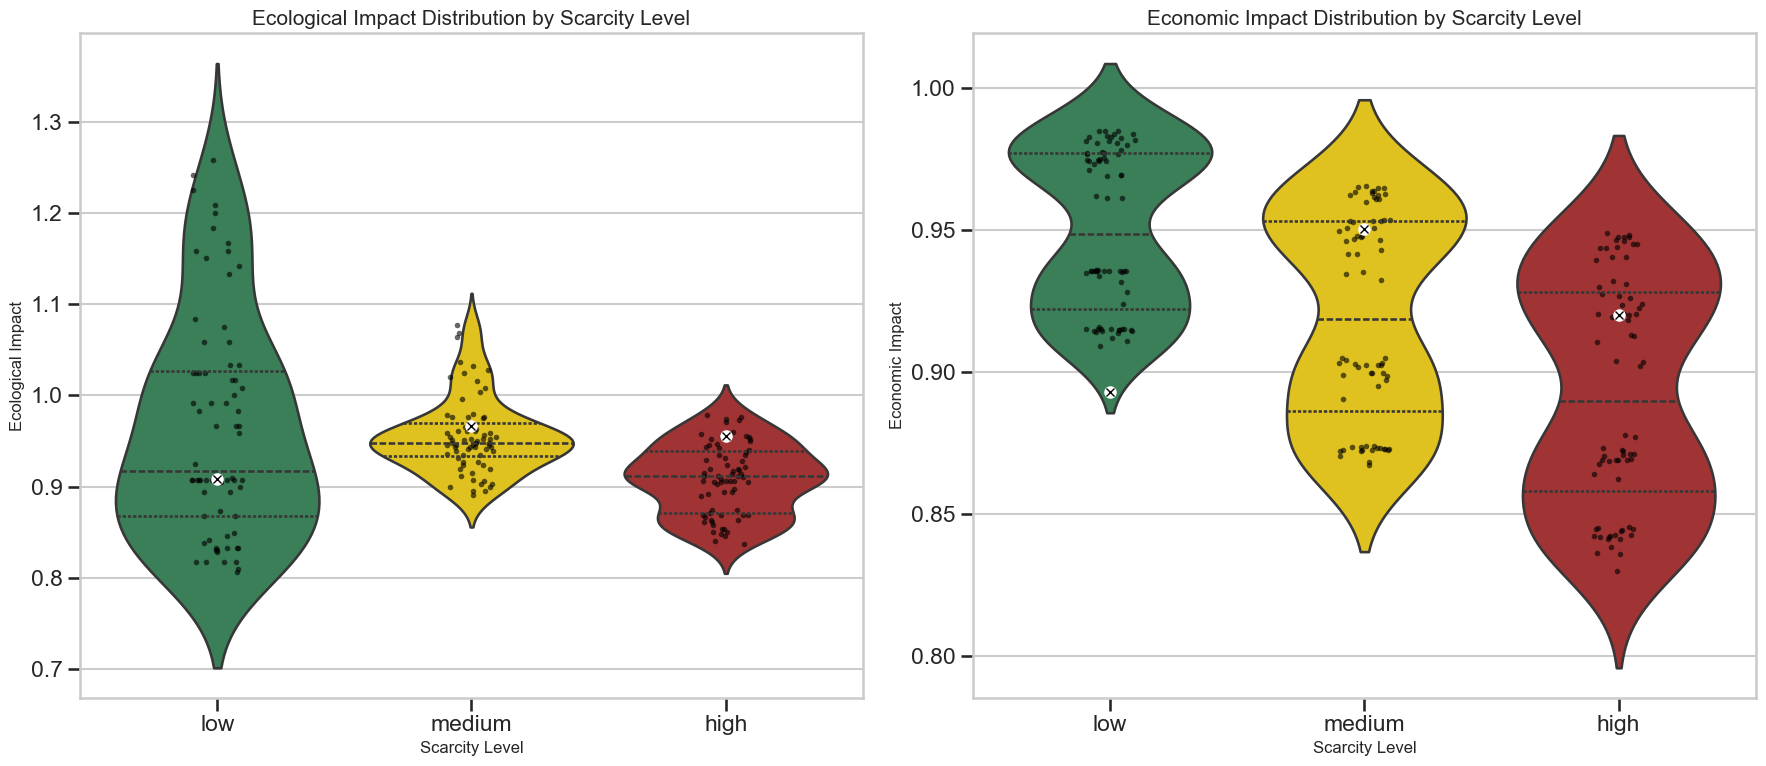

In [7]:
pma.analyze_forecast_effects(results_df)

## Correlation Analysis


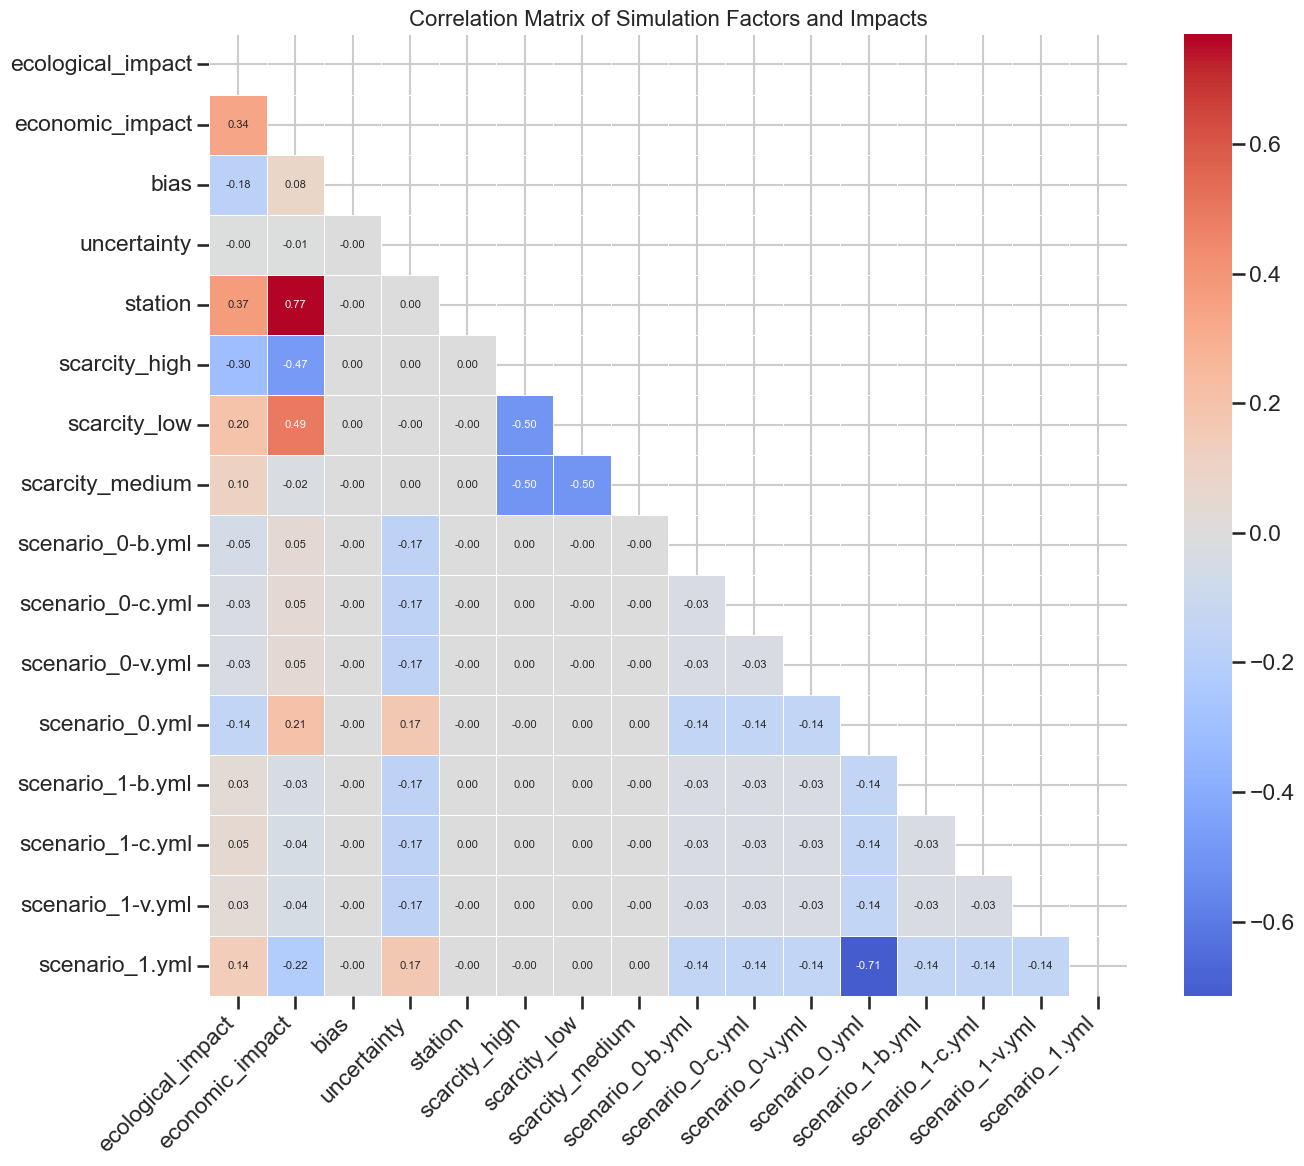

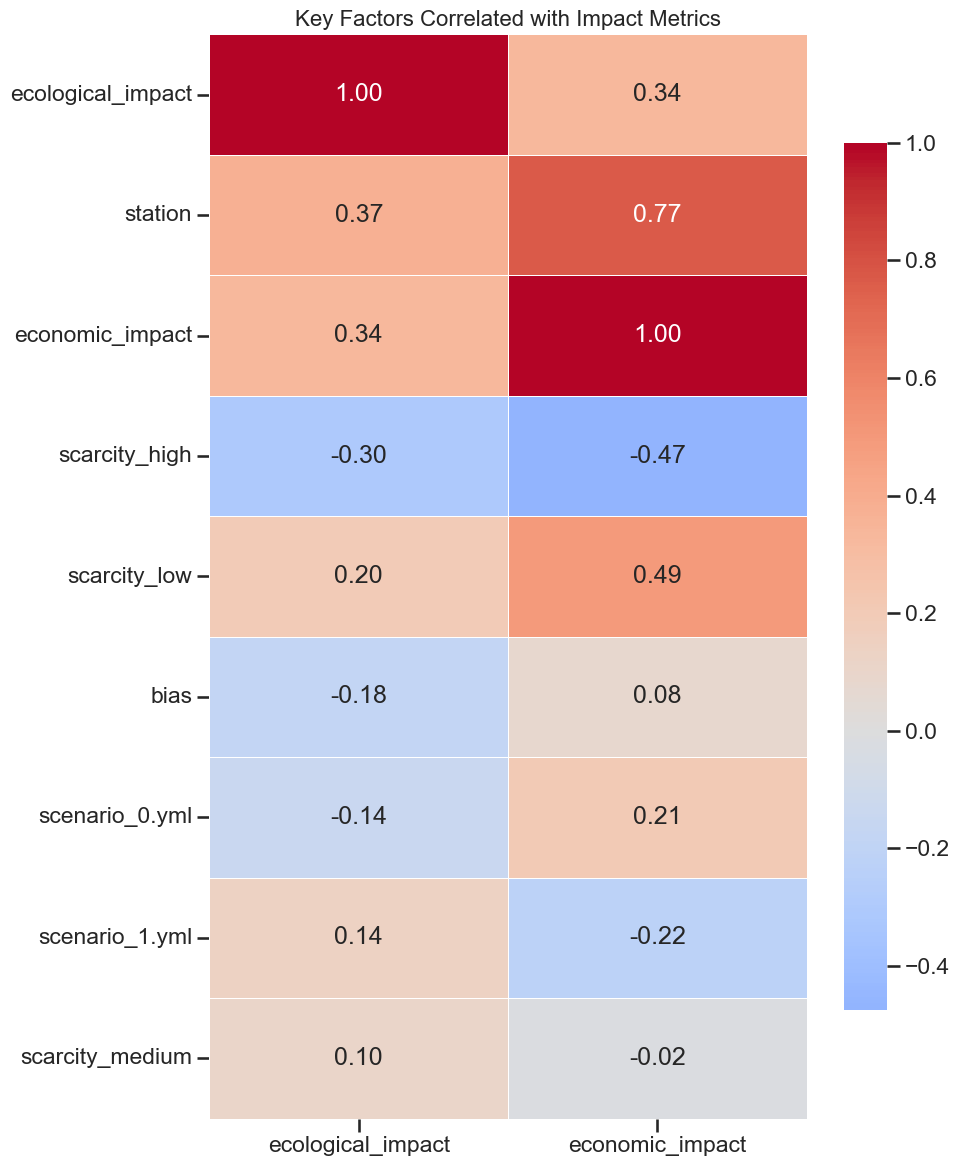

<Figure size 1200x1000 with 0 Axes>

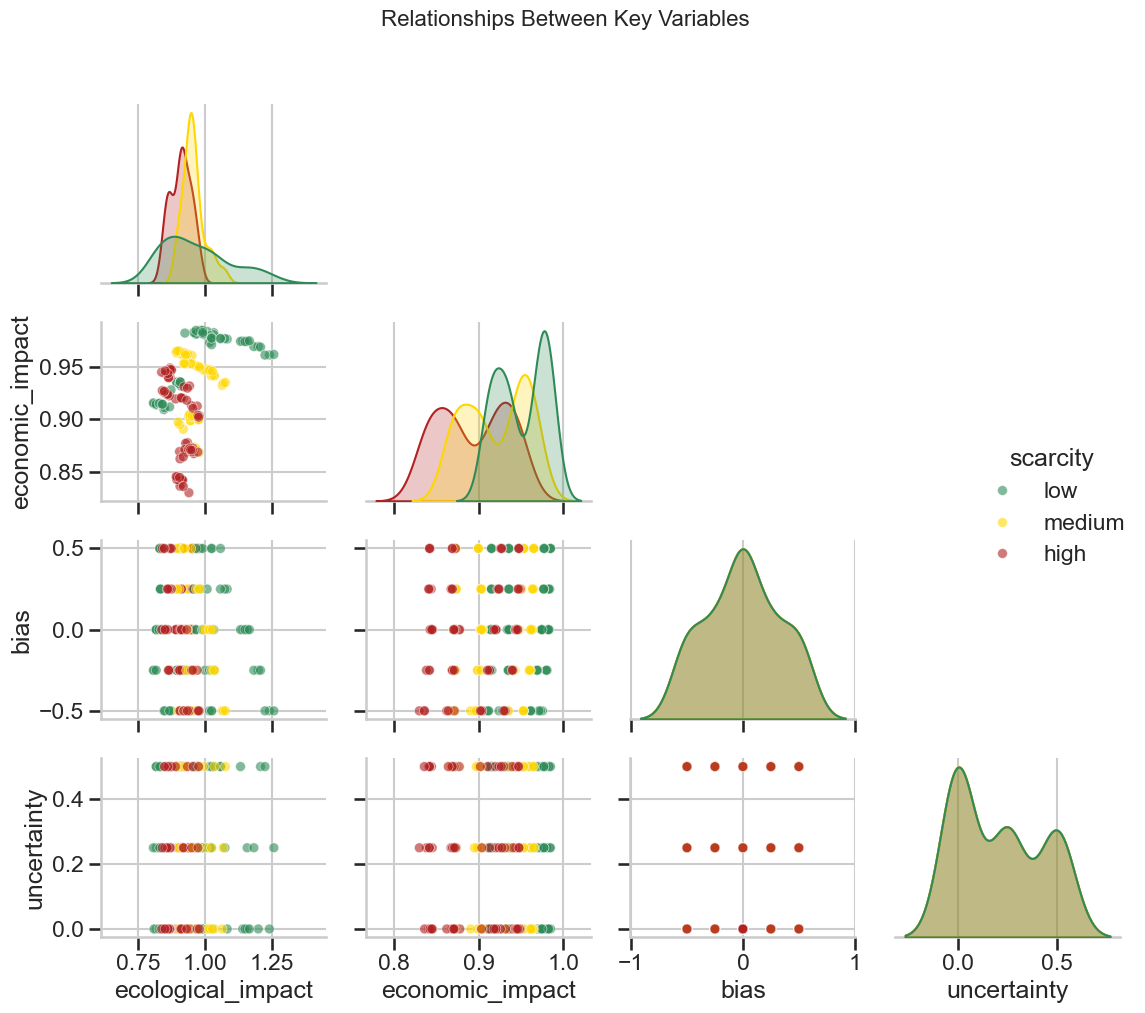

In [8]:
pma.correlation_analysis(results_df)

## Conclusion
This notebook has demonstrated how to analyze water allocation policies across multiple scenarios,
focusing on the balance between ecological and economic impacts. To participate in the hackathon:

1. Design your own adaptive policy by modifying the `custom_incentive_policy` and `custom_quota` functions
2. Test your policy across multiple scenarios using the tools provided
3. Optimize your policy to balance ecological integrity and economic benefits

Good luck!